In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cluster import DBSCAN

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


df_all = pd.read_csv('crimes_lahore_final 2014 to 2016 labeled by sayyab.csv', dtype="object")
df_all = df_all.apply(pd.to_numeric, errors='ignore')  # converted all numeric col into int/floats
print len(df_all)
df_all.dtypes

SyntaxError: invalid syntax (<ipython-input-2-279a30b57abb>, line 13)

In [2]:
df_all['Timestamp'] = df_all['incident_date'].astype(str).str.cat(df_all['incident_time'].astype(str), sep=' ')
df_all['Timestamp']=pd.to_datetime(df_all['Timestamp'],infer_datetime_format=True)
df_all.Timestamp.dt.time.head()


0    01:40:00
1    00:15:00
2    11:10:00
3    02:30:00
4    15:00:00
Name: Timestamp, dtype: object

In [3]:
groups=df_all.groupby('offence_category')
for name, crime in groups:
    if len(crime)>1000:
        print name, len(crime)

antinorcoticsact 7992
armsordinanceact 9650
attackongovtservant 1262
attemptedmurder 1969
beggingact 2984
burglary 9309
cartheft 3053
chequedishonour 9214
dengueact 3139
electricityact 2232
fatalaccident 1145
gambling 3767
hurtpersonalfeud 2559
kidnapping 1955
kiteflyingact 1640
localgovernment 1426
miscellaneous 46872
motorcycletheft 17452
narcotics 11456
othercrimes 33595
othervehicletheft 1369
outragingthemodestyofwomen 1805
overspeeding 14652
pricecontrol 9577
punjabarmsordinancebillof2015 3494
punjabinformationtemporaryresidenceordinance 5704
punjabsecurityordinance2015 1434
robbery 11584
telephoneact 1282


In [4]:
list_crimes=['cartheft','motorcycletheft', 'othervehicletheft','bulgery','murder','robbery','dacoity', 'dacoitywithmurder',
            'antinorcoticsact','punjabsecurityordinance2015', 'overspeeding', 'fatalaccident','chequedishonour',
            'armsordinanceact','blindmurder ', 'kidnapping', 'rap','blindmurder','policeencounter','hurtpersonalfeud',
            'narcotics','outragingthemodestyofwomen','othercrimes','miscellaneous' ]
df=df_all.loc[df_all['offence_category'].isin(list_crimes)]
#df=df_all
print 'Total crimes: ', len(df) 
print df.groupby('offence_category').size()
#crimes_total_rel=np.asmatrix(crimes_groups).astype('float')/np.sum(np.asmatrix(crimes_groups))
#print crimes_total_rel, np.sum(crimes_total_rel)
#for name, crime in crimes_groups:
#    print name, ':',len(crime)


Total crimes:  177345
offence_category
antinorcoticsact                7992
armsordinanceact                9650
blindmurder                      254
cartheft                        3053
chequedishonour                 9214
dacoity                          168
dacoitywithmurder                 27
fatalaccident                   1145
hurtpersonalfeud                2559
kidnapping                      1955
miscellaneous                  46872
motorcycletheft                17452
murder                           930
narcotics                      11456
othercrimes                    33595
othervehicletheft               1369
outragingthemodestyofwomen      1805
overspeeding                   14652
policeencounter                  179
punjabsecurityordinance2015     1434
robbery                        11584
dtype: int64


In [5]:
coordinates = df.as_matrix(columns=['Lat','Long'])

In [6]:
db = DBSCAN(eps=.000007840, min_samples=9, metric='haversine').fit(coordinates)
labels = db.labels_

print 'Total clusters: '+ str(len(set(labels)) - (1 if -1 in labels else 0))
df['db_clusters']=labels
db_clusters=df.groupby('db_clusters')
#for name, cluster in db_clusters:
#    print name ,':',len(cluster)

Total clusters: 39


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


If we visualise clusters, 
1- we will notice that clusters are of varying density. Like populas areas of the city are all respesented as one cluster because of high density 
while ares in suburb have smaller cluster sizes because of lower population hence crime density.
2- DBSCan cluster points based on globalised parameter while we need some localised tuning as well.
DBScan is not a good clustering technique here.
Thats why HDBScan seems like a good choice.

## HDBScan


In [7]:
import hdbscan
hdb=hdbscan.HDBSCAN(min_cluster_size=9, gen_min_span_tree=True, metric='haversine').fit_predict(coordinates)
labels=hdb
df['hdb_c']=labels
print 'Total clusters: '+ str(len(set(labels)) - (1 if -1 in labels else 0))
#df.groupby('hdb_c').size()


Total clusters: 3985


C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


For further visualization saving data frame as csv

In [8]:
#df.to_csv('clusters_all_v1_db_hdb.csv')
#print df_all.head(5)

#Lets pivot the dataframe to get appropriate structure for further cluster analysis
hdb_crimes_aggregate=pd.pivot_table(df, index=['hdb_c'],values='id', columns=['offence_category'], aggfunc='count')
hdb_crimes_aggregate=hdb_crimes_aggregate.fillna(0)
#Removing herarchical structure 

hdb_crimes_aggregate=hdb_crimes_aggregate.reset_index()

hdb_crimes_aggregate.head(5)

offence_category,hdb_c,antinorcoticsact,armsordinanceact,blindmurder,cartheft,chequedishonour,dacoity,dacoitywithmurder,fatalaccident,hurtpersonalfeud,...,motorcycletheft,murder,narcotics,othercrimes,othervehicletheft,outragingthemodestyofwomen,overspeeding,policeencounter,punjabsecurityordinance2015,robbery
0,-1,2009.0,2522.0,133.0,1398.0,1573.0,93.0,16.0,360.0,1099.0,...,7438.0,508.0,3024.0,13683.0,595.0,873.0,3133.0,66.0,493.0,5046.0
1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0
3,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0


In [9]:
crimes_header=list(hdb_crimes_aggregate.columns.values)
crimes_header.remove('hdb_c')
#print crimes_header
crimes_matrix_hdb=hdb_crimes_aggregate.as_matrix(columns=crimes_header)

#lets validate pivoting by counting total crimes by types

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

#Relative total counts of crimes--> this will be used in chi-sqaured distance
crimes_total_rel=crimes_matrix_hdb.sum(axis=0)/crimes_matrix_hdb.sum()
print crimes_total_rel, np.sum(crimes_total_rel)

[ 0.05  0.05  0.    0.02  0.05  0.    0.    0.01  0.01  0.01  0.26  0.1
  0.01  0.06  0.19  0.01  0.01  0.08  0.    0.01  0.07] 1.0


Lets Find similar clusters based on crime composition.
there are two measures for this:
## Brays Curtice
Brays curtis index assume the clusters are of same area size
## Chi-Squared distance 

In [10]:
a=crimes_matrix_hdb[10]
b=crimes_matrix_hdb[20]
def chi_squared_distance(u, v):
    global  crimes_total_rel
    rel_u=u/np.sum(u)
    rel_v=v/np.sum(v)
    #print np.sum(u), np.sum(v)
    #print np.sum(rel_u), np.sum(rel_v)
    return np.sqrt(np.sum(np.square(rel_u-rel_v)/crimes_total_rel))
print chi_squared_distance(a,b)


1.99874578322


In [11]:
from scipy import spatial

#BraysCurtise Distance
distance_braycurtise = spatial.distance.pdist(crimes_matrix_hdb, metric='braycurtis')
dist_matrix_brayscustis=spatial.distance.squareform(distance_braycurtise)
np.savetxt("brayscurtice_distance_hdb_all.csv", dist_matrix_brayscustis, delimiter=",")

#Chi-Sqaured Distance
distance_chi_squared = spatial.distance.pdist(crimes_matrix_hdb, metric=chi_squared_distance)
print distance_chi_squared
#convert distance matrix into squreform
dist_matrix_chi_sqaured=spatial.distance.squareform(distance_chi_squared)
np.savetxt("chi_sqaured_distance_hdb_all.csv", dist_matrix_chi_sqaured, delimiter=",")



[ 1.94  3.32  3.23 ...,  3.95  3.95  0.  ]


Above distace matrix was saved in file to objectively evaluate the clustering we are going to do now.
Now, We want to find similar gruop of clusters by using braycurtise distance. since we do not know how many gruop of clusters there might be. Herarchichal clustering seems like a good approach.
Lets try H Clustering


In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import spatial
from scipy.cluster.hierarchy import cophenet

#Z_single =linkage(X,method='single', metric='braycurtis')
brayscurtise_complete =linkage(crimes_matrix_hdb, method='complete', metric='braycurtis')
chi_squared_complete =linkage(crimes_matrix_hdb,  method='complete', metric=chi_squared_distance)


c, coph_dists = cophenet(brayscurtise_complete, spatial.distance.pdist(crimes_matrix_hdb, metric='braycurtis'))
print 'Complete, Brays Curtise :',c

c, coph_dists = cophenet(chi_squared_complete, spatial.distance.pdist(crimes_matrix_hdb, metric=chi_squared_distance))
print 'Complete Chi-Squared :',c



Complete, Brays Curtise : 0.38638602171
Complete Chi-Squared : 0.660744507716


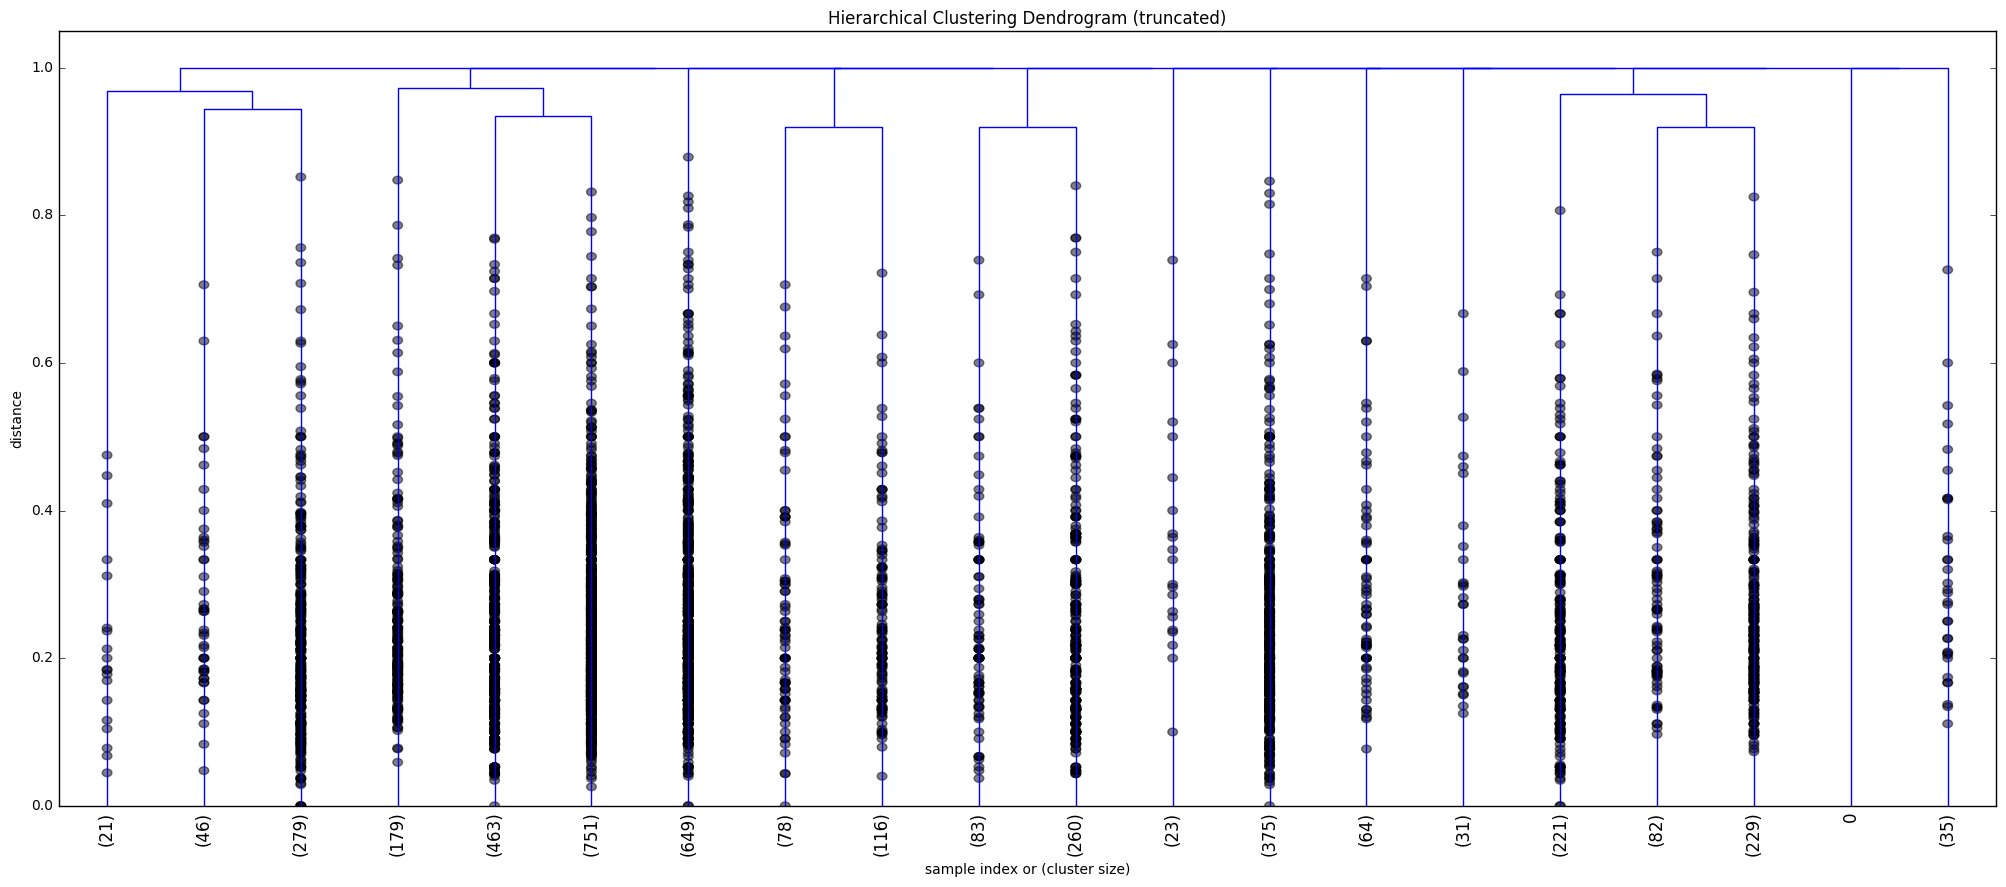

In [13]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    brayscurtise_complete,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

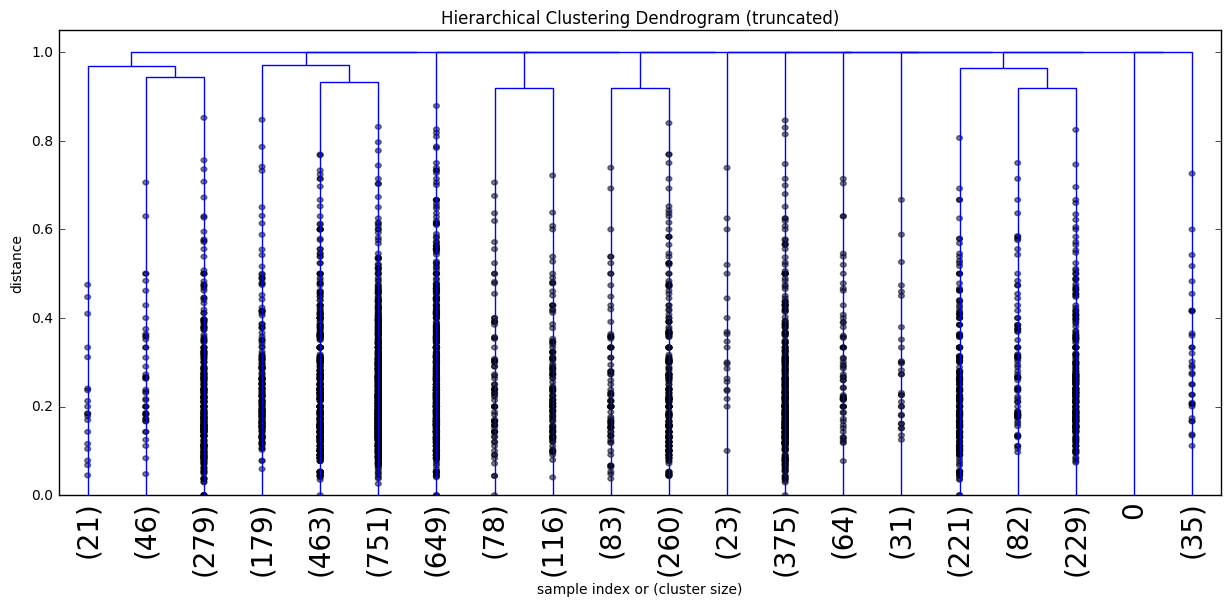

In [14]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    brayscurtise_complete,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

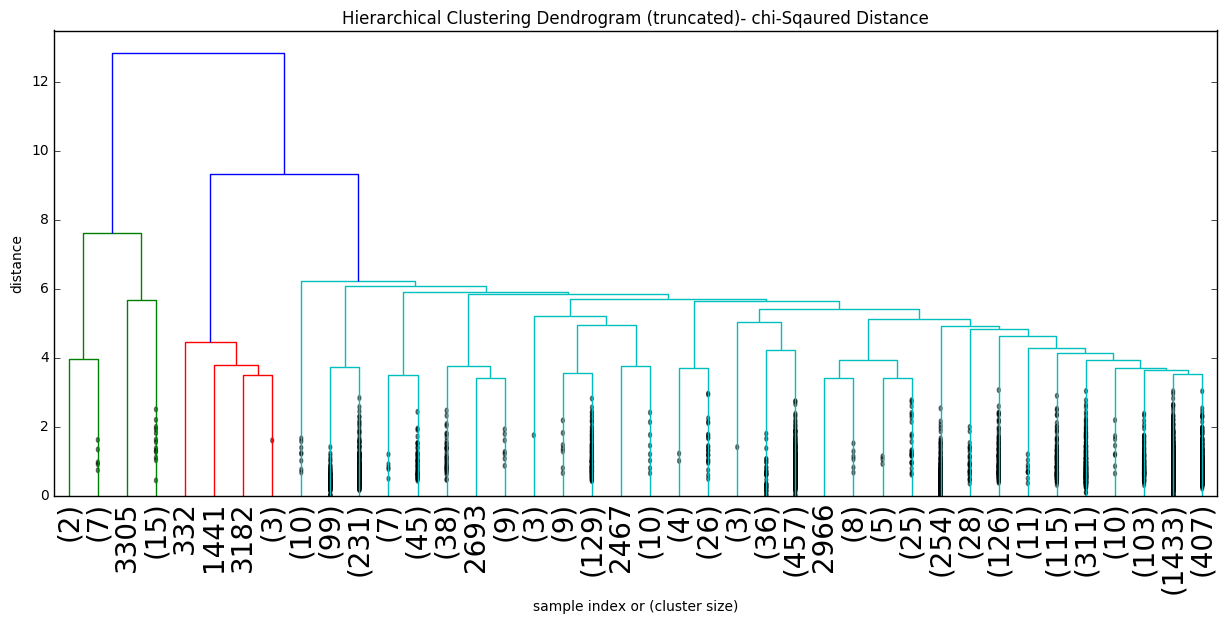

In [15]:
plt.title('Hierarchical Clustering Dendrogram (truncated)- chi-Sqaured Distance')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    chi_squared_complete,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=40,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()


## Selecting a Distance Cut-Off aka Determining the Number of Clusters

As explained above already, a huge jump in distance is typically what we're interested in if we want to argue for a certain number of clusters. If you have the chance to do this manually, i'd always opt for that, as it allows you to gain some insights into your data and to perform some sanity checks on the edge cases. In our case i'd probably just say that our cut-off is 0.7, as the jump is pretty obvious:
Let's visualize this in the dendrogram as a cut-off line:


In [16]:
# set cut-off
brays_curtis_max_d = 0.4  # max_d as in max_distance
chi_sqaured_max_d=3

from scipy.cluster.hierarchy import fcluster
brays_clusters_40 = fcluster(brayscurtise_complete, brays_curtis_max_d, criterion='distance')
chi_clusters_3 = fcluster(chi_squared_complete,chi_sqaured_max_d, criterion='distance')
print 'Total Brays clusters distance= ',brays_curtis_max_d, str(len(set(brays_clusters_40)) - (1 if -1 in labels else 0))
print 'Total Chi-Sqaured clusters distance=',chi_sqaured_max_d, str(len(set(chi_clusters_4)) - (1 if -1 in labels else 0))

Total Brays clusters distance=  0.4 598
Total Chi-Sqaured clusters distance= 3

NameError: name 'chi_clusters_4' is not defined

In [ ]:
#Lets try inconsistency method to cutt-off

from scipy.cluster.hierarchy import fcluster

brays_clusters_incon=fcluster(brayscurtise_complete, 8, depth=10)
print 'Total clusters: '+ str(len(set(brays_clusters_incon)))

chi_clusters_incon=fcluster(chi_squared_complete, 8, depth=10)
print 'Total clusters: '+ str(len(set(chi_clusters_incon)))


In [ ]:
#Lets join the cluster labels with existing datafram
hdb_crimes_aggregate['level2_brays_clusters_40']=brays_clusters_40
hdb_crimes_aggregate['level2_chi_clusters_3']=chi_clusters_3
hdb_crimes_aggregate.to_csv('clusters_hdb_analysis_level2_brays_chi.csv')
hdb_crimes_aggregate[hdb_crimes_aggregate['level2_chi_clusters_3']==10].head(12)

In [ ]:
hdb_crimes_aggregate.groupby('level2_brays_clusters_40').size()


In [ ]:
size=hdb_crimes_aggregate.groupby('level2_chi_clusters_3').size()
size[size>10]

In [ ]:
#Lets map level 1 and level 2 clusters
hdb_chi_map=dict(zip(hdb_crimes_aggregate.hdb_c,hdb_crimes_aggregate.level2_chi_clusters_3))
hdb_brays_map=dict(zip(hdb_crimes_aggregate.hdb_c,hdb_crimes_aggregate.level2_brays_clusters_40))
#print hdb_chi_map
#print hdb_brays_map
df['level2_chi_clusters_3']=df.hdb_c
df['level2_brays_clusters_40']=df.hdb_c

df.level2_chi_clusters_3.replace(to_replace=hdb_chi_map, inplace=True)
df.level2_brays_clusters_40.replace(to_replace=hdb_brays_map, inplace=True)
df.head()

In [ ]:
print len(df)
df.to_csv('hdb_level2_brays_chi_clustering_on_selected_crimes.csv', sep=',')